In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
ir = pd.read_excel('офз.xlsx', index_col=0, header=1) / 100 / 360

In [3]:
dates = np.array(['-'.join(x.split('.')[::-1]) for x in ir.index]).astype('M8[D]')
ir.index = dates
ir.sort_index(inplace=True)
dates = dates[::-1][1:]

In [4]:
ir_diff = ir.diff().dropna()# берем разности

In [5]:
pca = PCA(n_components=3)
components = pca.fit_transform(ir_diff)

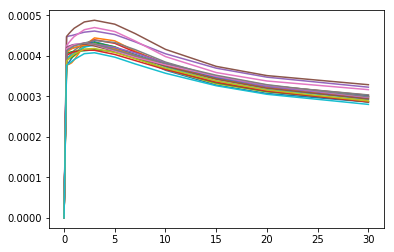

In [6]:
for i in range(20):
    plt.plot(np.concatenate((np.zeros(1), ir.columns)), np.concatenate((np.zeros(1), ir.iloc[i].values)))

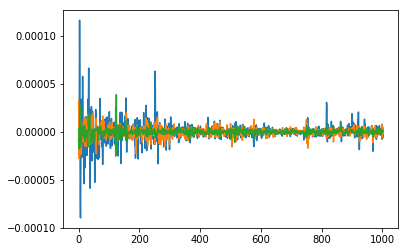

In [7]:
for i in range(3):
    plt.plot(components[:,i])

explain_var for 3 comp 0.954 %


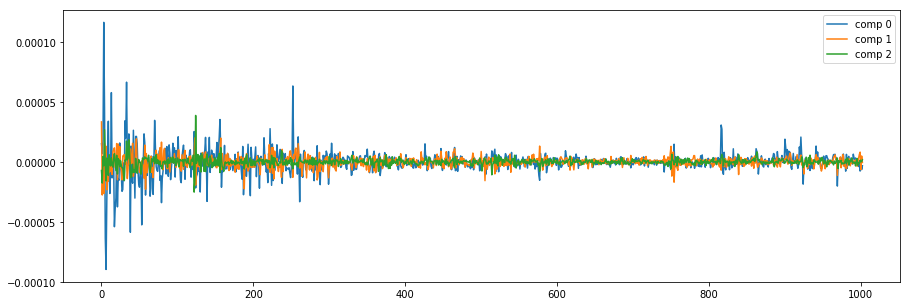

In [8]:
print(f"explain_var for 3 comp {pca.explained_variance_ratio_[:3].sum():.3f} %")
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(components[:,i], label=f"comp {i}")
plt.legend();

In [9]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [10]:
#tsplot(components[dates[:]>np.datetime64('2016-12-10'),2])

In [11]:
# import statsmodels.tsa.stattools as ts

# result = ts.adfuller(components[dates[:]>np.datetime64('2016-12-10'),1]) # maxlag is now set to 1
# result

In [88]:
def ClosestTradeDate(day, dates = dates, back=1):
    return dates[dates <= day][-back]

last traid date before forecase 2018-11-30
forecast date 2018-12-03


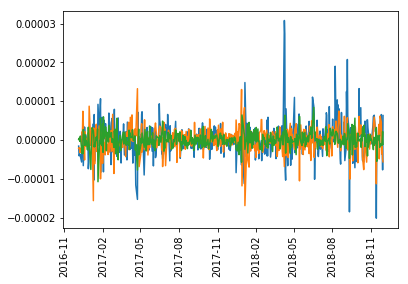

In [89]:
forecastDate = np.datetime64('2018-12-03')
tradeDate1 = ClosestTradeDate(forecastDate-1)
tradeDate10 = ClosestTradeDate(forecastDate-10)
startDate = np.datetime64('2016-12-03')

print('last traid date before forecase', tradeDate1)
print('forecast date', forecastDate)

#logr = np.log(first_comp[dates < forDate] - min(first_comp[dates < forDate]) + 0.002)
components_for = components[(dates <= tradeDate1) & (dates >= startDate)]

r0_diff = components_for[-1] # разница ставок в момент tradeDate1 для каждой из компоненты
r0 = ir.loc[tradeDate1] # реальная кривая в момент времени tradeDate1

plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,0])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,1])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,2])

plt.xticks(rotation=90);

__Vasicek Model:__ $dr_t = \alpha(b-r_t)dt + \sigma dW_t$   
Точное решение: $r_t \sim N\left(r_0 e^{-\alpha t} + b (1-e^{-\alpha t}),\,\tfrac{\sigma^2}{2\alpha}\left(1-e^{-2\alpha t}\right)\right)
$

In [67]:
def minimizeNLogLikelihood(r, dates):
    dt = 1 
    rt = r    
    N = r.shape[0]
    params0 = np.array([0.0000001,0.0000001,0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return -(N-1)*np.log(alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))) \
            - alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))*np.sum(-(rt[:-1] - rt[1:]*np.exp(-alpha*dt)-b*(1-np.exp(-alpha*dt)))**2) 
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [68]:
params = np.zeros((3,3))

for i in range(3):
    params[i] = minimizeNLogLikelihood(components[:,i], dates)
params

array([[ 1.55725007e+00,  1.97531386e-08,  1.31673617e-05],
       [ 4.45544839e+00, -5.60316396e-08,  1.07952882e-05],
       [ 3.24052327e+00,  1.27272068e-08,  6.13522912e-06]])

In [69]:
bond_count = 5
bond_info = {}

for bond_i in range(bond_count): 
    coupons_i = pd.read_excel('офз_график_выплат.xlsx', sheet_name=bond_i)[['Date', 'Coupon']].astype({'Date':'M8[D]'})   

    info = pd.read_excel('офз_описание.xlsx', bond_i, index_col=0)
    num_coupons = info.loc['Периодичность выплаты купона в год'].values[0]
    face = info.loc['Номинальная стоимость'].values[0]
    expDate = np.datetime64(info.loc['Дата погашения'].values[0])

    coupons_rate = coupons_i['Coupon'].values / num_coupons / 100
    coupons_date = coupons_i['Date'].values 
#     coupons_rate = coupons_rate[coupons_date > tradeDate1]  
#     coupons_date = coupons_date[coupons_date > tradeDate1].reshape(-1,1)
    
    bond_info[bond_i] = {
        'coupons_date': coupons_date,
        'coupons_rate': coupons_rate,
        'expDate': expDate,
        'faceValue': face,
        'num_coupons': num_coupons
    }
for i in bond_info:
    print(i)
    print(bond_info[i]['coupons_rate'][-1])
    print(bond_info[i]['expDate'])
    print()

0
0.038
2021-04-14T00:00:00.000000

1
0.04075
2027-02-03T00:00:00.000000

2
0.035
2023-01-25T00:00:00.000000

3
0.03525
2028-01-19T00:00:00.000000

4
0.032
2020-05-27T00:00:00.000000



In [70]:
# генерируем приращения после pca для момента forDate 
def VasicekPath(params,r0, N):
    dt = 1    
    alpha, b, sigma = params[0], params[1], params[2]
    r = [] # варианты аля-ставки на один из аля-TtM  
    for j in range(N):
        r1 = r0 + alpha*(b-r0)*dt + sigma*np.sqrt(dt)*np.random.randn()
        r.append(r1)
    return r

In [71]:
#Для каждой из облигации симулируем N 'ставок' по каждой из компоненты для момента for Date
#на выходе для каждой из облигации у нас будет матрица размером N*n_comp

N = 100
for bond_i in range(bond_count):
    print('bond', bond_i)
    r = []    
    for j in range(params.shape[0]):        
        r.append(VasicekPath(params[j], r0_diff[j], N))
    bond_info[bond_i]['simulations'] = np.array(r).T

bond 0
bond 1
bond 2
bond 3
bond 4


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

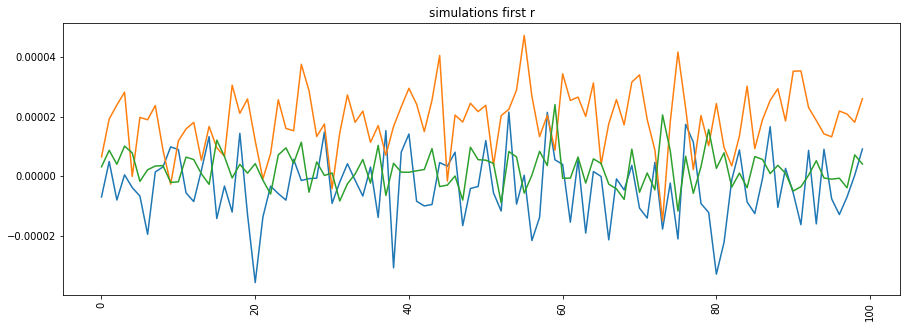

In [72]:
#пример симуляции N ставок для каждой из компоненты

bond_i = 1 # далее будем смотреть на конкретную облигацию
bond_result = bond_info[bond_i]

dates_index = pd.date_range(forecastDate, bond_result['expDate'])[:-1]

plt.figure(figsize =(15,5))
plt.subplot(111)
plt.plot(bond_result['simulations'][:, :])
plt.title('simulations first r')
plt.xticks(rotation=90)

In [115]:
r0.values

array([0.00019944, 0.00020194, 0.00020472, 0.00020778, 0.00021917,
       0.00022722, 0.00023694, 0.00024139, 0.00024472, 0.00024694,
       0.00024778, 0.00024861])

In [116]:
pca.inverse_transform(bond_result['simulations'])[0]

array([-6.21246980e-06, -5.57855186e-06, -4.56403917e-06, -3.52363059e-06,
       -5.46776146e-07,  4.47627693e-07,  6.16798519e-07,  2.13972344e-07,
       -3.02644770e-07, -8.32863357e-07, -1.07959748e-06, -1.29395602e-06])

In [117]:
r0.values + pca.inverse_transform(bond_result['simulations'])[0]

array([0.00019323, 0.00019637, 0.00020016, 0.00020425, 0.00021862,
       0.00022767, 0.00023756, 0.0002416 , 0.00024442, 0.00024611,
       0.0002467 , 0.00024732])

In [118]:
r0.values + np.cumsum(pca.inverse_transform(bond_result['simulations'])[0])

array([0.00019323, 0.00019015, 0.00018837, 0.0001879 , 0.00019874,
       0.00020724, 0.00021758, 0.00022224, 0.00022527, 0.00022666,
       0.00022642, 0.00022595])

In [119]:
#переводим аля-ставки в разности реальных ставок 
inverse_r = pca.inverse_transform(bond_result['simulations'])

#переводим разности в кривую YTM. 
inverse_r = r0.values + inverse_r

In [121]:
#используем линейную интерполяцию (дневную)
from scipy.interpolate import interp1d

x = [0]+list(r0.index*360)
xnew = np.arange(1, 30*360, 1)

inverse_r_interpolate = np.zeros((inverse_r.shape[0], len(xnew)))

for i, ofz in enumerate(inverse_r):
    y = [0]+list(ofz)
    
    f = interp1d(x, y)
    ynew = f(xnew)
    
    inverse_r_interpolate[i] = ynew

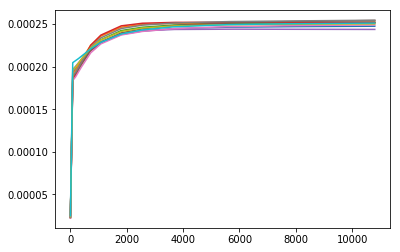

In [122]:
# наши смоделированные N кривыx на дату forDate
from scipy.interpolate import interp1d

for i in range(10):
    plt.plot(xnew[10:], inverse_r_interpolate[i, 10:]);

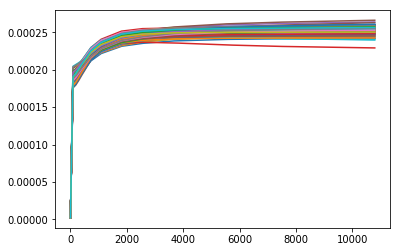

In [123]:
for i in range(inverse_r_interpolate.shape[0]):
    plt.plot(inverse_r_interpolate[i])

In [124]:
# def PriceCouponBond(yeild_curves, tradeDate, forecastDate, bond_info):
#     coupons_rate = bond_info['coupons_rate'][bond_info['coupons_date'] > tradeDate]
#     coupons_date = bond_info['coupons_date'][bond_info['coupons_date'] > tradeDate]
#     num_coupons = bond_info['num_coupons']
#     faceValue = bond_info['faceValue']
#     lag = (forecastDate - tradeDate)
    
#     TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate)/np.timedelta64(1,'D')), 1, coupons_date)
#     B = np.zeros((yeild_curves.shape[0],2))
#     for i in range(N):    
#         #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
#         for j,_ in enumerate(TimeToMaturity):        
#             V = faceValue*coupons_rate[j]/num_coupons if j != len(TimeToMaturity)-1 
#                 else faceValue*(1+coupon_rate[j]/num_coupons)  
#             discount_today = (1+yeild_curves[i][TimeToMaturity[j]]/num_coupons)**TimeToMaturity[j]
#             discount_tomorrow = (1+yeild_curves[i][TimeToMaturity[j]-1]/num_coupons)**(TimeToMaturity[j]-1)
#             B[i][0] += (V/discount_today)
#             B[i][1] += (V/discount_tomorrow)
#     return B

In [125]:
def PriceCouponBond(yeild_curves, tradeDate, bond_info):
    coupons_rate = bond_info['coupons_rate'][bond_info['coupons_date'] > tradeDate]
    coupons_date = bond_info['coupons_date'][bond_info['coupons_date'] > tradeDate].reshape(-1,1)
    num_coupons = bond_info['num_coupons']
    faceValue = bond_info['faceValue']
    
    TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate)/np.timedelta64(1,'D')), 1, coupons_date)
    B = np.zeros((N, TimeToMaturity[-1]))
    discount_factor = ((1+inverse_r_interpolate[:, :TimeToMaturity[-1]])**np.arange(TimeToMaturity[-1]))[:, ::-1]

    for i in range(N):    
        #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
        for j,_ in enumerate(TimeToMaturity):        
            V = faceValue*coupons_rate[j]/num_coupons if j != len(TimeToMaturity)-1 else faceValue*(1+coupons_rate[j]/num_coupons) 
            B[i, :TimeToMaturity[j]] += (V / discount_factor[i, :TimeToMaturity[j]])
    return B

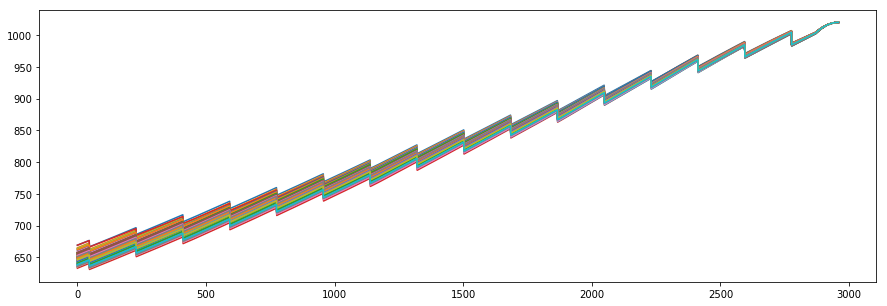

In [126]:
price_bond = PriceCouponBond(inverse_r_interpolate, tradeDate1, bond_result)
plt.figure(figsize=(15,5))
for i in range(price_bond.shape[0]):
    plt.plot(price_bond[i])

### Прогноз и VaR на 1 день

In [127]:
market_i = pd.read_excel('офз_данные.xlsx', bond_i, usecols=[2,7]).set_index('<DATE>')

In [152]:
lag1 = int((forecastDate-tradeDate1)/np.timedelta64(1,'D'))
yeilds1 = (price_bond[:, lag1] - price_bond[:, 0])/price_bond[:,0]

In [146]:
market_yeilds1 = (market_i.loc[forecastDate]['<CLOSE>'] - market_i.loc[tradeDate1]['<CLOSE>'])/\
    market_i.loc[tradeDate1]['<CLOSE>']

In [129]:
forecast1 = market_i.loc[tradeDate1]['<CLOSE>']*(1+yeilds1)

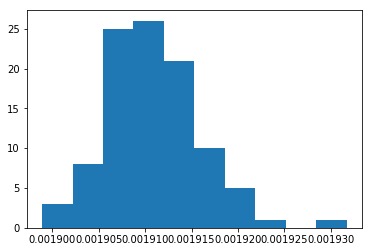

In [149]:
plt.hist(market_yeilds1 - yeilds1, bins=10);

In [151]:
np.percentile(market_yeilds1 - yeilds1, 99)

0.0019225749233423325

### Прогноз и VaR на 10 дней

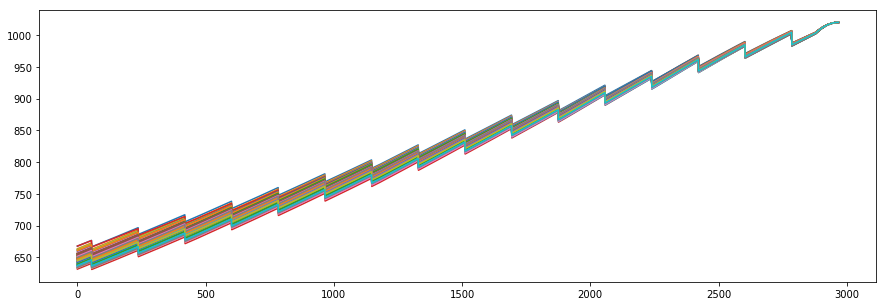

In [131]:
price_bond10 = PriceCouponBond(inverse_r_interpolate, tradeDate10, bond_result)
plt.figure(figsize=(15,5))
for i in range(price_bond10.shape[0]):
    plt.plot(price_bond10[i])

In [132]:
lag10 = int((forecastDate-tradeDate10)/np.timedelta64(1,'D'))
yeilds10 = (price_bond10[:, lag10] - price_bond10[:, 0])/price_bond10[:,0]

In [133]:
forecast10 = market_i.loc[tradeDate10]['<CLOSE>']*(1+yeilds10)

In [134]:
np.percentile(market_i.loc[forecastDate]['<CLOSE>'] - forecast10, 99)

0.45690048395193206

## Backtesting 

In [98]:
year_start = np.datetime64('2018-01-01')
year_end = ('2019-01-01')

In [112]:
r0.values

array([0.00019944, 0.00020194, 0.00020472, 0.00020778, 0.00021917,
       0.00022722, 0.00023694, 0.00024139, 0.00024472, 0.00024694,
       0.00024778, 0.00024861])

In [114]:
inverse_r[0]

array([0.00020351, 0.00020637, 0.00020932, 0.00021231, 0.00022195,
       0.00022823, 0.00023645, 0.00024133, 0.00024498, 0.00024667,
       0.00024698, 0.00024704])

In [154]:
N = 100
for forecastDate in dates[(dates >= year_start) & (dates <= year_end)]:
    tradeDate1 = ClosestTradeDate(forecastDate-1)
    tradeDate10 = ClosestTradeDate(forecastDate-10)
    startDate = ClosestTradeDate(forecastDate-730) # начало окна    

#     print('window', startDate, tradeDate1)
#     print('forecast date', forecastDate)

    components_for = components[(dates <= tradeDate1) & (dates >= startDate)]
    r0_diff = components_for[-1] # разница ставок в момент tradeDate1 для каждой из компоненты
    r0 = ir.loc[tradeDate1] # реальная кривая в момент времени tradeDate1
    
    params = np.zeros((3,3))
    for i in range(3):
        params[i] = minimizeNLogLikelihood(components[:,i], dates)
    
    for bond_i in range(bond_count):
        # генерируем сценарии для главных компонент
        r = [VasicekPath(params[j], r0_diff[j], N) for j in range(params.shape[0])]        
        # преобразуем сценарии компонент в сценарии разностей реальных ставок 
        inverse_r = pca.inverse_transform(np.array(r).T)
        # переводим сценарии разностей в сценарии кривых доходностей 
        inverse_r = r0.values + np.cumsum(inverse_r,0)
        # интерполируем
        x = [0]+list(r0.index*360)
        yeild_curves = np.zeros((inverse_r.shape[0], len(xnew)))

        for i, ofz in enumerate(inverse_r):
            y = [0]+list(ofz)
            f = interp1d(x, y)
            ynew = f(xnew)
            yeild_curves[i] = ynew
        
        
        

KeyboardInterrupt: 